<a href="https://colab.research.google.com/github/samuel0922/TEAM_SSAMJI/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%A0%84%EC%B2%98%EB%A6%AC_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 데이터셋 다운로드
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

# PL_data_oladter.py => 구글 드라이브에 있는 파일 다운로드 함수 저장
# --data 파라미터에 FaceMaskDetection을 입력함으로써 
# 마스크 착용 탐지 모델 구축에 활용할 데이터를 받을 수 있음
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

# 압축 풀기 : 리눅스 명령어 unzip. -q : 불필요한 출력물 안나오게 제어
# annotations
# images
!unzip -q Face\ Mask\ Detection.zip

In [ ]:
import os

# 바운딩박스 도식화 위한 패키지 임포트
import glob  # 파일, 디렉토리 처리
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg  # matplotlib 시각화
import matplotlib.patches as patches
from bs4 import BeautifulSoup  # HTML, XML 파일 파싱, 웹스크래핑 

from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt

import random

from tqdm import tqdm
import pandas as pd
from collections import Counter

## 2. 데이터 탐색 및 바운딩 박스 확인

In [ ]:
# 데이터셋 불러옴
# sorted() : img_list에 있는 파일의 id 순서와 
# annot_list에 있는 파일 id 순서를 맞춰줌

img_list = sorted(glob.glob('/content/drive/MyDrive/mask_detection/images/*'))
annot_list = sorted(glob.glob('/content/drive/MyDrive/mask_detection/annotations/*'))

In [ ]:
# 각 폴더에 있는 파일 갯수 확인

print(img_list)
print(len(img_list))
print(len(annot_list))

['/content/drive/MyDrive/mask_detection/images/Face Mask Detection.zip', '/content/drive/MyDrive/mask_detection/images/Tutorial-Book-Utils', '/content/drive/MyDrive/mask_detection/images/annotations', '/content/drive/MyDrive/mask_detection/images/images', '/content/drive/MyDrive/mask_detection/images/maksssksksss0.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss1.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss10.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss100.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss101.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss102.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss103.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss104.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss105.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss106.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss107.png', '

In [ ]:
# 각각의 폴더에 들어있는 파일 내용 확인
# 10개씩 출력해 봄. 단, 출력되는 파일이 순서대로 나오는지 확인
# 순서대로 출력되지 않을 경우 
# 이미지 파일과 바운딩 박스 파일의 순서가 뒤얽혀 바운딩 박스가 제대로 표기되지 않는 문제가 발생
print(img_list[:10])
print(annot_list[:10])

['/content/drive/MyDrive/mask_detection/images/Face Mask Detection.zip', '/content/drive/MyDrive/mask_detection/images/Tutorial-Book-Utils', '/content/drive/MyDrive/mask_detection/images/annotations', '/content/drive/MyDrive/mask_detection/images/images', '/content/drive/MyDrive/mask_detection/images/maksssksksss0.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss1.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss10.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss100.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss101.png', '/content/drive/MyDrive/mask_detection/images/maksssksksss102.png']
['/content/drive/MyDrive/mask_detection/annotations/maksssksksss0.xml', '/content/drive/MyDrive/mask_detection/annotations/maksssksksss1.xml', '/content/drive/MyDrive/mask_detection/annotations/maksssksksss10.xml', '/content/drive/MyDrive/mask_detection/annotations/maksssksksss100.xml', '/content/drive/MyDrive/mask_detection/annotations/ma

In [ ]:
# 바운딩박스 시각화 함수 정의

# xmin, ymin, xmax, ymax 값을 반환하도록 지정
def generate_box(obj):
    '''
    xmin, ymin, xmax, ymax 값을 반환하도록 지정
    '''

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    '''
    마스크 착용 여부를 세 단계로 나눠서 0, 1, 2값 반환
    with_mask 1,mask_weared_incorrect 2, without_mask 0
    '''
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(file): 
    '''
    generate_box, generate_label를 각각 호출해 반환된 값을 딕셔너리에 저장해 반환
    annotation 파일에 있는 내용들을 불러와 타겟의 바운딩 박스와 라벨을 추출
    html.parser를 이용해 annotations파일에 있는 내용들을 불러와 타겟의 바운딩 박스와 라벨 추출
    '''
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image(img_path, annotation):
    '''
    이미지와 바운딩 박스를 함께 시각화
    마스크 착용시 초록색, 마스크를 올바르게 착용안했을 때 주황색, 마스크 키착용시 빨강색으로 그림
    '''
    img = mpimg.imread(img_path)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
# index() : 특정 파일의 인덱스 값 확인

img_list.index('/content/drive/MyDrive/mask_detection/images/maksssksksss307.png')

236

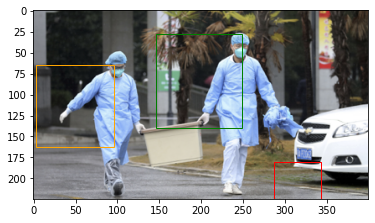

In [ ]:
# plot_image() : 이미지 위에 바운딩박스 시각화
# img_list[]와 annot_list[]안 숫자는 해당 이미지 파일의 위치를 의미하므로 같은 숫자가 들어감

# generate_target() : 이미지 파일에 해당하는 바운딩 박스 정보를 bbox에 저장함
bbox = generate_target(annot_list[232])

# plot_image함수에 바운딩 박스 정보와 더불어 해당 이미지 파일 정보도 넘겨줘 시각화
plot_image(img_list[232], bbox)

## 3. 데이터 전처리

* 인기 있는 데이터셋의 경우 수천 수만 장의 이미지를 가지고 있지만, 모든 데이터셋이 그렇지 못함
* 제한된 데이터셋을 학습시키기 위해서는??
* 데이터셋이 부족한 경우 augmentation을 이용해 다양한 상태의 이미지 데이터를 얻을 수 있음
=> 파이토치에서 활용할 수 있는 augmentation 모듈
* torchvision.transforms : 파이토치 공식 제공 모듈 -> 이미지 분류용 모델에 사용 가능
* albumentations : OpenCV와 같은 오픈 소스 컴퓨터 비젼 라이브러리를 최적화 함 -> 다른 라이브러리보다 더 빠른 처리 속도 및 기타 기능 제공. 이미지 분류 및 객체 탐지용 모델 구축에도 사용 가능
* 객체 탐지용 이미지 augmentation은 이미지 뿐만 아니라 바운딩 박스까지 변형해 주어야 하는데, torchvision.transforms에는 이런 기능 제공 않기 때문

In [ ]:
# !pip install --upgrade albumentations

In [ ]:
# augmentation을 시각화 하기 위해 앞에서 선언한 바운딩박스 도식화 코드 활용
# 그렇지만 다른 점이 있는 것에 유의할 것.

# 라이브러리 임포트는 앞에 모두어 함

# import os
# import glob
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from bs4 import BeautifulSoup

def generate_box(obj):
    '''
    데이터 탐색에서 사용된 함수와 같음
    '''
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0


def generate_target(file): 
    '''
    추후 딥러닝 모델 학습을 위한 tensor간의 연산을 준비하기 위해
    torch.as_tensor함수가 추가 됨
    '''
    
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        # 추후 딥러닝 모델 학습을 위한 tensor간의 연산을 준비하기 위해
        # torch.as_tensor함수가 추가됨 
        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

# 새로운 함수 추가됨
def plot_image_from_output(img, annotation):
    '''
    데이터 탐색에서의 plot_image()는 이미지를 파일 경로에서 읽어오지만
    plot_image_from_output()은 torch.Tensor로 변환된 이미지를 시각화함

    Pytorch에서는 이미지를 [channel, height, width]로 표현하는 반면
    matplotlib에서는 [height, width, channels]로 표현하므로
    채널 순서를 바꿔주는 permute 함수를 활용해 matplotlib에서 사용하기 위한
    채널 순서로 바꿔줌
    '''
    img = img.permute(1,2,0)  # permute() : 이미지 표현하는 방식을 matplotlib용으로 바꿔줌
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

### 3.1 Torchvision Transforms
* PyTorch에서 제공하는 공식 augmentation용 모듈
* 이미지 분류용 모델에 사용
* 객체 탐색에는 bounding box에 대해서도 augmenatation을 해 줘야 하는데 Torchvision Trasnforms는 이 기능을 제공하지 않으므로 객체 탐색에는 사용되지 않음

In [ ]:
# from PIL import Image
# import cv2
# import numpy as np
# import time
# import torch
# import torchvision
# from torch.utils.data import Dataset
# from torchvision import transforms
# import albumentations
# import albumentations.pytorch
# from matplotlib import pyplot as plt
# import os
# import random

# Torchvision을 위한 데이터셋 정의 클래스

class TorchvisionMaskDataset(Dataset):
    '''
    __getitem__ 메소드 : image 불러옴 다음 데이터 augmentation을 진행
    transform 파라미터에 저장돼 있는 augmentaiton 규칙에 따라 augmantation이 이뤄짐
    시작 측정을 위해 time함수를 사용해 시간 측정 후
    최종적으로 image, label, total_time을 반환해 줌
    '''

    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        
        target = generate_target(label_path)
        
        start_t = time.time()
        if self.transform:
            img = self.transform(img)

        total_time = (time.time() - start_t)

        return img, target, total_time

In [ ]:
# augmentation 실습 진행해 봄
# 이미지를 (300, 300)크기로 만든 후
# 224 크기로 자르도록 함
# 이미지의 밝기(brightness), 대비(contrast), 채도(saturation), 색조(hue)를 무작위로 바꿔좀
# 이미지 좌우 반전 적용한 후 tensor로 변환

torchvision_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # resize() : 이미지 크기 조정
    transforms.RandomCrop(224),  # 이미지 crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        # 밝기, 대비, 채도, 색조 등을 임의로 바꿔줌
    transforms.RandomHorizontalFlip(p = 1),  # 정의한 p의 확률로 좌우반전 실시
    transforms.ToTensor(),
])

torchvision_dataset = TorchvisionMaskDataset(
    path = 'images/',
    transform = torchvision_transform
)

transforms 적용 전


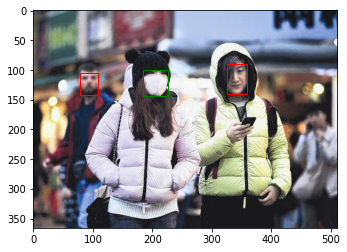

In [ ]:
# 변경 전후의 이미지 비교
'''
torchvision.transforms에서 제공하는 augmentation은 
이미지값에 대한 augmentation은 진행되지만,
바운딩박스에 대한 augmentation은 이뤄지지 않음
즉, 변경된 이미지에 대해서 올바르게 바운딩 박스를 잡아주지 못함
'''

only_totensor = transforms.Compose([transforms.ToTensor()])

torchvision_dataset_no_transform = TorchvisionMaskDataset(
    path = 'images/',
    transform = only_totensor
)

# transforms 적용 전

img, annot, transform_time = torchvision_dataset_no_transform[0]
print('transforms 적용 전')
plot_image_from_output(img, annot) 

transforms 적용 후


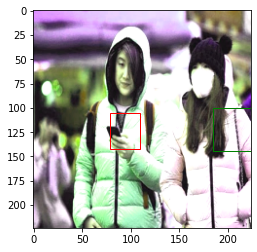

In [ ]:
# transforms 적용 후 : 바운딩박스의 위치가 변경전과 달라짐

img, annot, transform_time = torchvision_dataset[0]

print('transforms 적용 후')
plot_image_from_output(img, annot)

In [ ]:
# torchvision.transfroms와 albumentation의 이미지 변환 시간 비교를 위해
# torchvision 적용한 이미지 변환에 소요된 속도 측정을 위해 100번 적용
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time: {} ms".format(total_time*10))

### 3-2. Albumentations 

In [ ]:
# Albumentation 최신 버전 설치

# ! pip install albumentations==0.5.2.

In [ ]:
# 데이터셋 클래스 정의

class AlbumentationsDataset(Dataset):
    '''
    torchvision 데이터셋과 비슷한 구조
    cv2 모듈을 이용해 이미지를 읽고 RGB로 바꿔줌
    이미지 변환을 실시한 후 결과값을 반환함
    '''
    
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        # Read an image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented['image']
        
            
        return image, target, total_time

In [ ]:
# torchvision.transforms와 속도 비교를 위해 같은 함수들 사용해 처리
# Same transform with torchvision_transform

albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1), 
    albumentations.HorizontalFlip(p=1), 
    albumentations.pytorch.transforms.ToTensorV2()
])

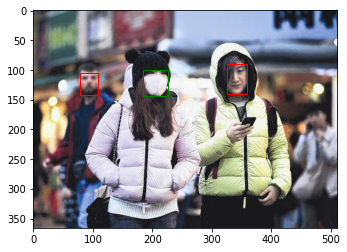

In [ ]:
# albumentation적용 변경 전
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(img, annot)

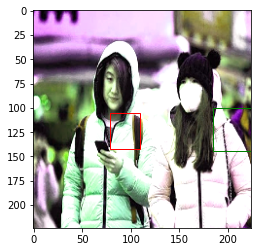

In [ ]:
# albumentation 적용 변경 후
albumentation_dataset = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform
)

img, annot, transform_time = albumentation_dataset[0]
plot_image_from_output(img, annot)

In [ ]:
# torchvision.transfroms와 albumentation의 이미지 변환 시간 비교를 위해
# albumentation 적용 변환에 소요된 속도 측정을 위해 100번 적용
total_time = 0
for i in range(100):
    sample, _, transform_time = albumentation_dataset[0]
    total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))

albumentations time/sample: 1.3907957077026367 ms


### 3-3. 확률 기반 Augmentation 조합
* Albumentation은 torchvision.transforms보다 속도가 빠를 뿐 아니라 새로운 기능도 제공
#### OneOf()
* list 안에 있는 augmentaiton 기능들을 주어진 확률값에 기반해 가져옴
* list 값 자체의 확률 값과 더불어 해당 함수의 확률 값을 함께 고려해 실행 여부 결정
* 아래의 OneOf()함수는 각각 선택될 확률이 1임.
* 각각의 함수 내부에 있는 albumentation기능들 또한 각각 확률값이 1로 부여됐으므로, 실질적으로 1/3의 확률로 3개의 기능 중 하나가 선택되어 실행됨
* 이렇게 확률값을 조정하여 다양한 aumentation이 가능해 짐

In [ ]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),  # 이 OneOf()함수가 선택될 확률은 1, 그 내부 함수들의 선택가능성도 1
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensorV2()
])

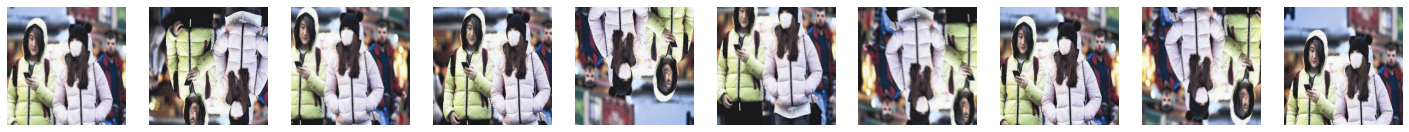

In [ ]:
# albumentatios_transform_oneof()를 이미지에 10번 적용한 결과

albumentation_dataset_oneof = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
  ax[i].axis('off')

### 3-4. 바운딩박스 Augmentation
* 객체 탐지 모델 구축 시에는 이미지에 대한 augmentaiton 진행 시에 
* 이미지 변환 뿐만 아니라, 그에 따른 바운딩박스 변환 또한 함께 진행해 줘야 함
#### compose(bbox_params)
* Albumentation에서 제공하는 Compose()함수의 bbox_params 파라미터 활용해 바운딩 박스 augmentation 가능

In [ ]:
# 바운딩 박스 augmentation을 위한 새로운 데이터셋 클래스 생성

class BboxAugmentationDataset(Dataset):
    '''
    AlbumentationDataset클래스의 transform부분 수정
    이미지 뿐만 아니라 바운딩박스도 transform이 진행되도록 필요한 입력값, 출력값 수정해줌
    '''

    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        # Read an image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        # 이 부분이 이미지 augmentation에 적용하는 내용과 다른 부분임.
        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}
        
            
        return image, target

        # 이 부분은 이미지 augmentation에 적용되는 내용임. 비교를 위해
        # start_t = time.time()
        # if self.transform:
        #     augmented = self.transform(image=image)
        #     total_time = (time.time() - start_t)
        #     image = augmented['image']


        # return image, target, total_time

In [ ]:
# Compse() : 변환 정의 
# 바운딩박스에 사용할 format을 파라미터로 정해줌
'''
1) 좌우반전
2) -90~90사이의 회전
3) 바운딩박스 변환을 위해 bbox_params에 albumentation.BboxParams객체 입력해 줌
4) FaceMaskDetection데이터셋의 바운딩박스 표기법이 xmin, ymin, xmax, ymax로 되어 있고
이것은 pascal_voc 표기법과 같음 -> format 파라미터에 pascal_voc를 입력해 줌
5) transform진행 시 객체별 클래스 값은 labels파라미터에 저장하기 위해 label_field에 labels를 저장
'''
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

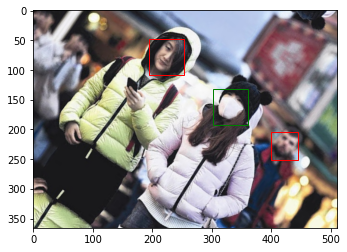

In [ ]:
# BboxAugmentationDtataset 클래스를 활성화 해 augmentation 결과물 확인
# 위 코드를 싱핼할 때마다 이미지도 변환되어 출력되고, 
# 더불어 바운딩박스도 알맞게 변환되어 변환된 이미지에 있는 마스크 착용 얼굴들을 정확히 탐지
bbox_transform_dataset = BboxAugmentationDataset(
    path = 'images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

In [ ]:
### 1-2. 데이터 분리
* 학습 데이터와 시험 데이터 분리
* 일반적으로 학습데이터와 테스트데이터는 7:3 으로, 데이터 수가 적을 때는 8:2로 분리


In [ ]:
# 전체 데이터 갯수 확인

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

853
853


In [ ]:
# 시험데이터(이미지, annotation)를 저장할 폴더  만들어줌

!mkdir test_images
!mkdir test_annotations

In [ ]:
# import random

# random.sample() : 무작위로 숫자를 추출해 인덱스값으로 활용

random.seed(1234)
idx = random.sample(range(853), 170)
print(len(idx))
print(idx[:10])

170
[796, 451, 119, 7, 92, 826, 596, 35, 687, 709]


In [ ]:
# 만든 폴더로 이미지 파일과 annotation파일을 옮겨줌

# import numpy as np
import shutil  # 이미지와 좌표 파일들을 각각의 지정 폴더로 옮겨주기 위한 라이브러리

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

FileNotFoundError: ignored

In [ ]:
# 테스트용 파일을 만든 폴더로 옮겼으니까 폴더별로 파일 갯수를 확인해 봄

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

In [ ]:
# 라이브러리 임포튼 앞에 모두어

# from tqdm import tqdm
# import pandas as pd
# from collections import Counter


'''
이미지 분류문제에서는 학습용, 시험푱 데이터를 나눈 후 이미지 갯수만 확인하면 되지만
객체 탐비 문제에서는 각 클래스 별로 몇 개의 객체가 데이터셋 내부에 존재하는지 확인 필요
'''

# 데이터셋 내부에 있는 클래스별 객체 수 확인하는 함수
def get_num_objects_for_each_class(dataset):
    '''
    데이터셋에 있는 모든 바운딩박스의 라벨 값을 total_labels에 저장후
    Counter 클래스를 활용해 라벨별 개수를 세어 반환하는 함수

    학습용 데이터에는 0번 클래스 532개, 1번 클래스 2,691개, 2번 클래스 97개 
    시험용 데이터에는 0번 클래스 541개, 1번 클래스   541개, 2번 클래스 26개  
    '''

    total_labels = []

    for img, annot in tqdm(dataset, position = 0, leave = True):
        total_labels += [int(i) for i in annot['labels']]

    return Counter(total_labels)


train_data =  BboxAugmentationDataset(
    path = 'images/'
)

test_data =  BboxAugmentationDataset(
    path = 'test_images/'
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

print('\n train 데이터에 있는 객체', train_objects)
print('\n test 데이터에 있는 객체', test_objects)

## 5. Faster R-CNN 모델(2-Stage) 적용

In [ ]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
# !git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
# !python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
# !unzip -q Face\ Mask\ Detection.zip

In [ ]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

# !mkdir test_images
# !mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [ ]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

In [ ]:
torch.cuda.is_available()

In [ ]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

In [ ]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])